In [1]:
#Import and Install Dependencies
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [2]:
pwd

'C:\\Users\\Soldo\\Desktop\\Black_Rail_Audio_Files\\BLRA_Deep_Learning_Model'

In [3]:
BLRA_FILE = 'C:\\Users\\Soldo\\Desktop\\Black_Rail_Audio_Files\\BLRA_Deep_Learning_Model\\Parsed_BLRA_Clips\\BR_Call_1.wav'

In [4]:
NOT_BLRA_FILE = 'C:\\Users\\Soldo\\Desktop\\Black_Rail_Audio_Files\\BLRA_Deep_Learning_Model\\Parsed_Not_BLRA_Clips\\afternoon-birds-song-in-forest-1.wav'

In [5]:
#Build Data Loading Function
def load_wav_16k_mono(file_name):
    #Load encoded wav file
    file_contents = tf.io.read_file(file_name)
    # Decode wav (tensor by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hx - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

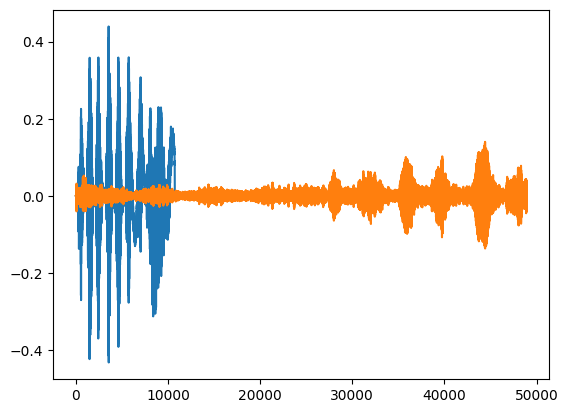

In [6]:
# Plot Wave
wave = load_wav_16k_mono(BLRA_FILE)
nwave = load_wav_16k_mono(NOT_BLRA_FILE)

plt.plot(wave)
plt.plot(nwave)
plt.show()

In [7]:
# Define wich folders contain the clips that have BLRA calls and which do not
POS = 'C:\\Users\\Soldo\\Desktop\\Black_Rail_Audio_Files\\BLRA_Deep_Learning_Model\\Parsed_BLRA_Clips'
NEG = 'C:\\Users\\Soldo\\Desktop\\Black_Rail_Audio_Files\\BLRA_Deep_Learning_Model\\Parsed_Not_BLRA_Clips'

In [8]:
# Create a variable that holds all of the files in each folder - searches for files with .wav at the end
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [9]:
# Make sure the previous code worked - should see any .wav file within the positive folder
pos.as_numpy_iterator().next()

b'C:\\Users\\Soldo\\Desktop\\Black_Rail_Audio_Files\\BLRA_Deep_Learning_Model\\Parsed_BLRA_Clips\\BR_Call_13.wav'

In [10]:
# How many .wav files are in the BLRA positive folder?
len(pos)

210

In [11]:
# How many .wav files are in the not BLRA folder?
len(neg)

210

In [12]:
# Add labels to each file and combine positive and negative samples into variable called "data"
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [13]:
# Determine the average length of a black rail call
# Calculate wave cycle length
lengths=[]
for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join(POS, file))
    lengths.append(len(tensor_wave))

In [14]:
# Show the array we just created of call lengths
lengths

# Note: There are several repetitions because the 210 clips were produced by copying and pasting the same 30 
# .wav files within the positives folder

[10753,
 10753,
 10753,
 10753,
 10753,
 10753,
 10753,
 20089,
 20089,
 20089,
 20089,
 20089,
 20089,
 20089,
 19876,
 19876,
 19876,
 19876,
 19876,
 19876,
 19876,
 17497,
 17497,
 17497,
 17497,
 17497,
 17497,
 17497,
 13374,
 13374,
 13374,
 13374,
 13374,
 13374,
 13374,
 16532,
 16532,
 16532,
 16532,
 16532,
 16532,
 16532,
 14675,
 14675,
 14675,
 14675,
 14675,
 14675,
 14675,
 17275,
 17275,
 17275,
 17275,
 17275,
 17275,
 17275,
 15919,
 15919,
 15919,
 15919,
 15919,
 15919,
 15919,
 13893,
 13893,
 13893,
 13893,
 13893,
 13893,
 13893,
 17275,
 17275,
 17275,
 17275,
 17275,
 17275,
 17275,
 10236,
 10236,
 10236,
 10236,
 10236,
 10236,
 10236,
 13746,
 13746,
 13746,
 13746,
 13746,
 13746,
 13746,
 13746,
 13746,
 13746,
 13746,
 13746,
 13746,
 13746,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 18619,
 17089,
 17089,
 17089,
 17089,
 17089,
 17089,


In [15]:
# Moving forward, we need to specify call length, so let's get some summary statistics
# Calculate Mean, Min, and Max
mean = tf.math.reduce_mean(lengths)
min = tf.math.reduce_min(lengths)
max = tf.math.reduce_max(lengths)

print(mean, min, max)

tf.Tensor(15165, shape=(), dtype=int32) tf.Tensor(7342, shape=(), dtype=int32) tf.Tensor(20089, shape=(), dtype=int32)


In [17]:
# Looks like the average length is approximately 15,000 - so that's what we'll go with

In [16]:
# Build preprocessing function to convert audio files to spectrograms
# Build preprocessing function

def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path) # Our data loading function
    wav = wav[:15000]
    zero_padding = tf.zeros([15000] - tf.shape(wav), dtype=tf.float32) # make sure we include all files below 15000
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

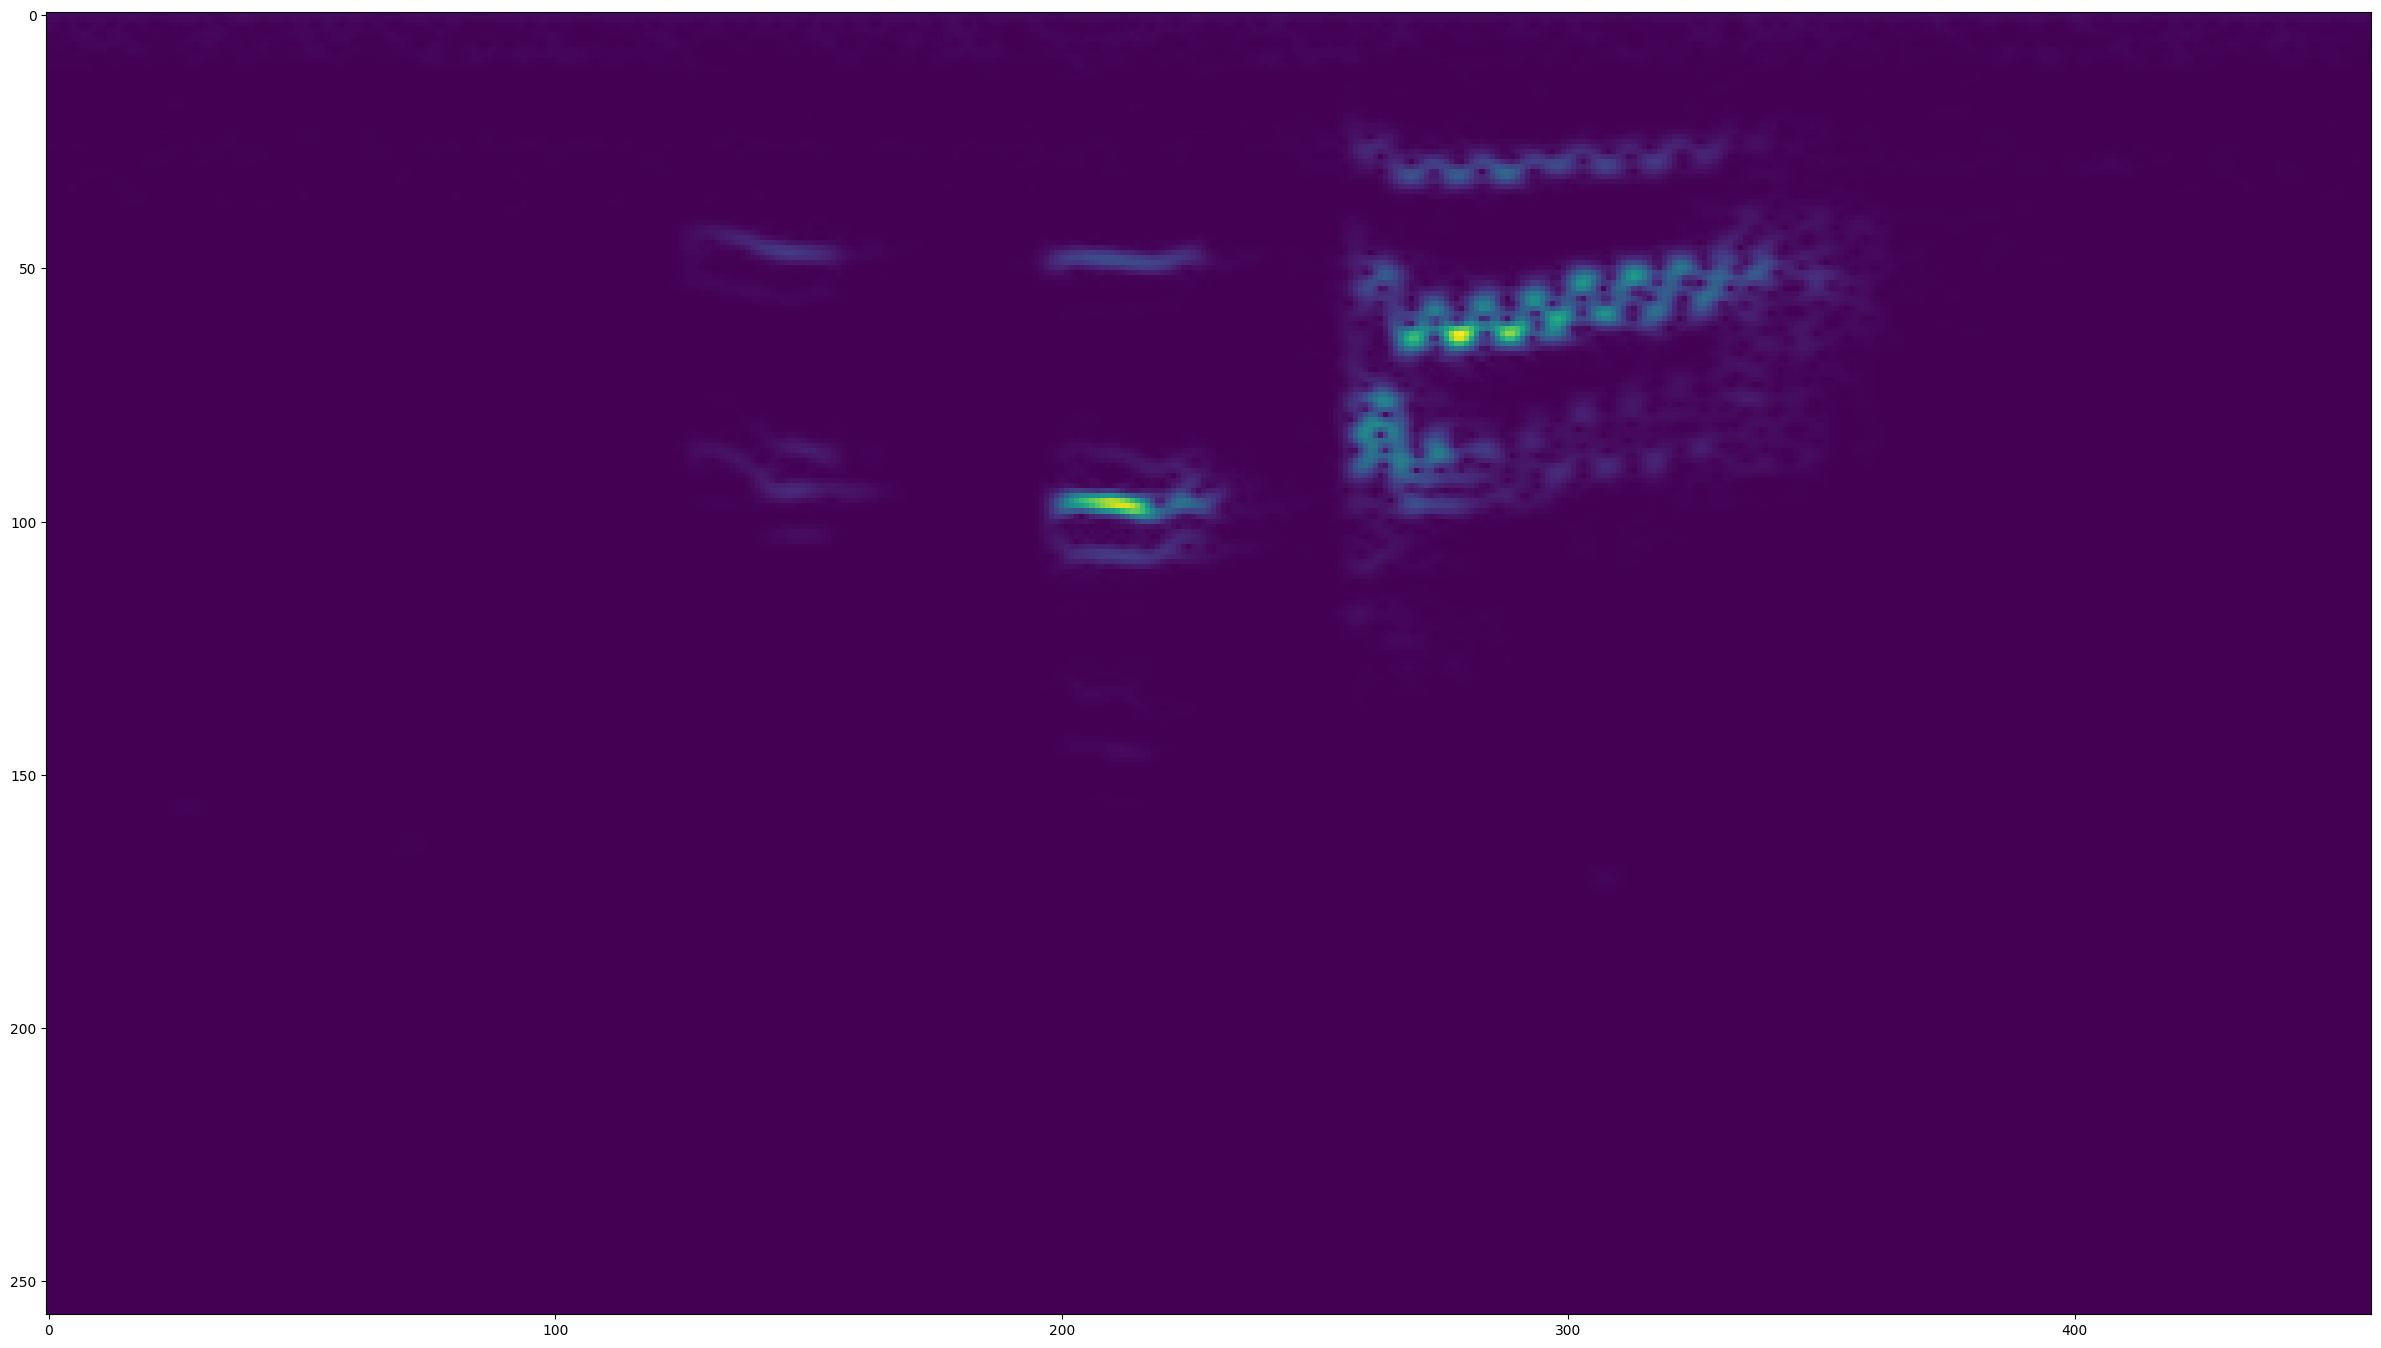

In [17]:
# Test out the function and viz of the spectrogram from the positives files
# Create a spectrogram from a black rail call
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

# Plot the spectrogram
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [18]:
# Create training and testing partitions
# Create a tensorflow data pipeline

data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000) # shuffle between pos & neg files - reduce bias
data = data.batch(16) # Train on 16 samples at a time
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [19]:
# What does our data look after preprocessing?
# Remember we are running test in batches of 16 
# so len(data) will return no. approx. 16X lower than total number of pos and neg files
len(data)

27

In [20]:
# Split into training and testing data 
# based on results of the previous code (i.e., take ~70% of data for training partition)
train = data.take(19)
test = data.skip(19).take(8)

In [21]:
# Test One Batch from the training data
# First number should be 16 - number of files in the batch
# Last 3 numbers are shape of spectrogram - need to pass through deep learning model
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 459, 257, 1)

In [22]:
# Check that the batch has mix of positive (1) and negative (1) clips
labels

array([0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
      dtype=float32)

In [23]:
# Build Deep Learning Model
# Load Tensorflow Dependencies
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [24]:
# Build sequential model, compile and view summary
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(459, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
# Compile the model
# Check out the parameters
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 457, 255, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 455, 253, 16)      2320      
                                                                 
 flatten (Flatten)           (None, 1841840)           0         
                                                                 
 dense (Dense)               (None, 128)               235755648 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 235,758,257
Trainable params: 235,758,257
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Fit Model, View Loss and KPI Plots
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
19/19 [==============================] - 61s 3s/step - loss: 4.2508 - recall: 0.9320 - precision: 0.8457 - val_loss: 0.1054 - val_recall: 1.0000 - val_precision: 0.9818
Epoch 2/4
19/19 [==============================] - 59s 3s/step - loss: 0.0532 - recall: 0.9675 - precision: 0.9868 - val_loss: 0.0367 - val_recall: 0.9672 - val_precision: 1.0000
Epoch 3/4
19/19 [==============================] - 59s 3s/step - loss: 0.0412 - recall: 0.9671 - precision: 1.0000 - val_loss: 0.0410 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
19/19 [==============================] - 60s 3s/step - loss: 0.0223 - recall: 0.9872 - precision: 1.0000 - val_loss: 0.0193 - val_recall: 1.0000 - val_precision: 1.0000


In [27]:
# Get some numbers of how the model performed
hist.history

{'loss': [4.250800609588623,
  0.0532342828810215,
  0.04115183278918266,
  0.022313192486763],
 'recall': [0.9319728016853333,
  0.9675324559211731,
  0.9671052694320679,
  0.9871794581413269],
 'precision': [0.845678985118866, 0.9867549538612366, 1.0, 1.0],
 'val_loss': [0.10538190603256226,
  0.03672059252858162,
  0.041028112173080444,
  0.0193018838763237],
 'val_recall': [1.0, 0.9672130942344666, 1.0, 1.0],
 'val_precision': [0.9818181991577148, 1.0, 1.0, 1.0]}

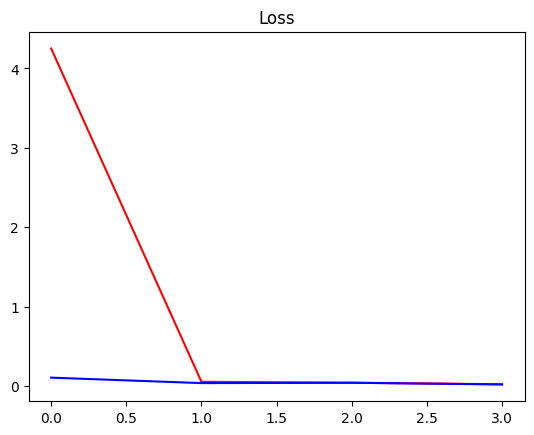

In [28]:
# Plot loss
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [29]:
# Make a prediction on a single clip
# Get one batch and make a prediction
X_test, y_test = test.as_numpy_iterator().next()

In [30]:
# Make sure the test includes 16 spectrograms
X_test.shape

(16, 459, 257, 1)

In [31]:
# Make sure the y_test has 16 labels
y_test.shape

(16,)

In [32]:
# Use your model to make some predictions!
yhat = model.predict(X_test)

1/1 [==============================] - 0s 316ms/step


In [33]:
# See how your model did - get logits or confidence metrics for each spectrogram in the batch
yhat

array([[1.1357958e-17],
       [1.0000000e+00],
       [1.0000000e+00],
       [8.5417414e-03],
       [2.7937510e-16],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.5183820e-01],
       [5.5741606e-04],
       [4.0888973e-03],
       [1.0000000e+00],
       [1.0015822e-03],
       [1.0000000e+00],
       [2.4279697e-07]], dtype=float32)

In [34]:
# Convert Logits to Classes
# Loop through each prediction - model is precise so raise confidence interval - let's say 95%
yhat = [1 if prediction > 0.95 else 0 for prediction in yhat]

In [35]:
# Display the new classes 
yhat

[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]

In [36]:
# How many rails were heard based on the model prediction?
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [37]:
# How many rails were heard based on the test data?
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [38]:
# Look at y_test as classes
y_test.astype(int)

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0])

In [39]:
# Try out the model on some new audio files
#Build parsing functions
#Load up MP3s

def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [40]:
mp3 = 'C:\\Users\\Soldo\\Desktop\\Black_Rail_Audio_Files\\BLRA_Deep_Learning_Model\\Audio_Files_To_Test_Model\\BLRA_Test_Clip2_Pos.mp3'

In [41]:
mp3

'C:\\Users\\Soldo\\Desktop\\Black_Rail_Audio_Files\\BLRA_Deep_Learning_Model\\Audio_Files_To_Test_Model\\BLRA_Test_Clip2_Pos.mp3'

In [42]:
wav = load_mp3_16k_mono(mp3)

In [43]:
# Convert "wav" file into slices for image recognition
# Remember - our sequence length is 15,000
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=15000, sequence_stride=15000, batch_size=1)

In [44]:
# Take one clip and slice it up
samples, index = audio_slices.as_numpy_iterator().next()
len(audio_slices)

58

In [45]:
#Build function to convert clip slices into windowed spectrograms
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([15000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [46]:
# Convert longer clips into windows and make predicitons
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=15000, sequence_stride=15000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [47]:
# Make predicitons on the mp3 files
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.95 else 0 for prediction in yhat]

1/1 [==============================] - 1s 936ms/step


In [48]:
# Take a look at our predictions
yhat

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [49]:
len(yhat)

58

In [50]:
# Group consecutive detections
from itertools import groupby

yhat = [key for key, group in groupby(yhat)]
tf.math.reduce_sum(yhat)
calls = tf.math.reduce_sum(yhat).numpy()
calls

6

In [90]:
pwd

'C:\\Users\\Soldo\\Desktop\\Black_Rail_Audio_Files\\BLRA_Deep_Learning_Model'

In [ ]:
#Make Prediction
#Loop over all recordings and make predictions

results = {}
for file in 'C:\\Users\\Soldo\\Desktop\\Black_Rail_Audio_Files\\BLRA_Deep_Learning_Model\\Audio_Files_To_Test_Model':
    FILEPATH = ('C:\\Users\\Soldo\\Desktop\\Black_Rail_Audio_Files\\BLRA_Deep_Learning_Model\\Audio_Files_To_Test_Model', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=15000, sequence_stride=15000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [1]:
results

NameError: name 'results' is not defined

In [ ]:
#Convert Predictions into Classes
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

In [ ]:
# Group Consecutive Detections
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

In [ ]:
# Export Results
import csv

with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])